# A and AB Testing Example Using Pymc3

The examples found here can be found from Cameron Davidson-Pilon's book, Bayesian Methods for Hackers [also available for free online on Github](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb).

Additional explanation of the process of A & A/B testing has been added for learning purposes and streamlined the code to make it easier to follow along.

## Import Libraries

In [1]:
# Math
import numpy as np

# Stats
import pymc3 as pm
import scipy.stats as stats

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

# A Testing
We'd like to figure out the posterior distribution of method A, which helps us see the probability distribution for different observed frequencies of signups to a hospital webpage. A testing is usually performed before AB testing to make sure that any observed differences in the AB test is not from the data collection method itself.

## Create a sample dataset that simulates the observed frequency

In [2]:
# use the uniform distribution for an unbiased prior
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [3]:
# This value is normally unknown, but for example's sake let's use 5% signup rate as the base to draw 1500 samples from. 
p_true = 0.05
N = 1500

# Get N samples from the bernoulli distribution with a 5% chance of signup (true probability)
# This represents 1500 data points collected from our website indicating signup/no signup. The mean signup rate should be close to 5%.
occurences = stats.bernoulli.rvs(p_true, size=N)

print(f'What is the observed frequency in Group A? {round( np.mean(occurences), 3 )}')
print(f'Does this equal the true frequency? { np.mean(occurences) == p_true }')

What is the observed frequency in Group A? 0.044
Does this equal the true frequency? False


## Sampling 18,000 points from the posterior distribution using MCMC

This samples data points from our model, which has defined to take into account the prior distribution and our observed occurences (list of 1500 data points indicating signup/no signup), to build the posterior distribution. Recall Bayes theorem:

\begin{equation*}
P(A|X) = \frac{P(X|A)P(A)}{P(X)}
\end{equation*}

In other words, what is the probability of our site, version A ($A$), given the 1500 data points ($X$) that were collected? The probability is returned as the posterior distribution.

Markov Chain Monte Carlo (MCMC) is the algorithm of choice for sampling the posterior distribution. It returns an object called *trace* that holds this distribution.

See Bayesian Methods for Hackers Chapter 3 (Cameron Davidson-Pilon) notes on MCMC sampling:

> 1.   The traces converges, not to a single point, but to a distribution of possible points. This is convergence in an MCMC algorithm.

> 2.   Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the burn-in period.

> 3.   The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. This will be detailed in the Diagnostics section later in this chapter.

In [4]:
# include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli('obs', p, observed=occurences)
    step = pm.Metropolis() # use Metropolis() for continuous variables, ElemwiseCategorical() for categorical variables
    trace = pm.sample(18000, step=step, cores=1, chains=1) # use cores=1 to not run parallel chains
    burned_trace = trace[1000:]

Sequential sampling (1 chains in 1 job)
Metropolis: [p]
100%|██████████| 18500/18500 [00:03<00:00, 6166.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


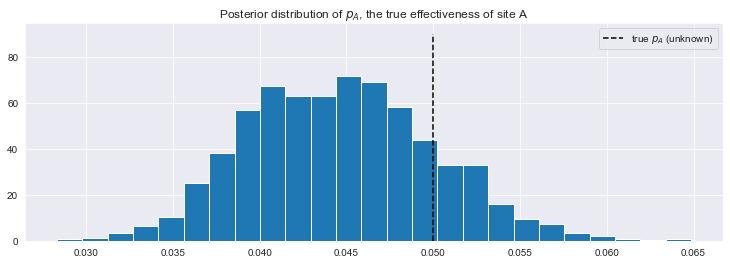

In [5]:
fig, ax = plt.subplots(figsize=(12.5, 4))
ax.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
ax.hist(burned_trace["p"], bins=25,  density=True, edgecolor='white')
ax.set_title("Posterior distribution of $p_A$, the true effectiveness of site A")
ax.legend();

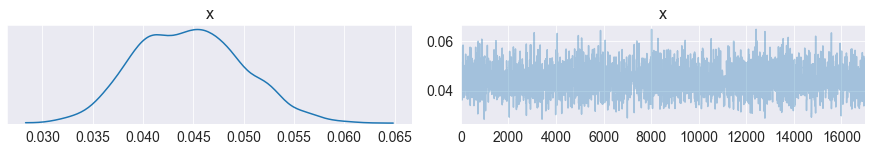

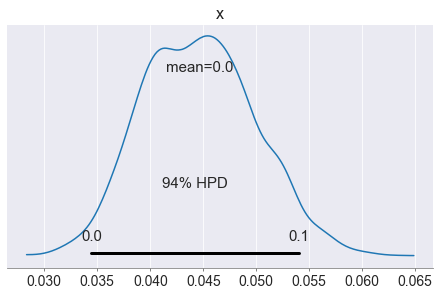

In [6]:
pm.plots.traceplot(data=burned_trace['p'])
pm.plots.plot_posterior(data=burned_trace['p']);

The first two plots above are the posterior distribution of $p_A$ and its trace plot, which is returned by the MCMC algorithm. The third plot provides additional information about the posterior distribution $p_A$. The horizontal bar indicates the *highest priority density interval* (HPD). The value indicates that there is a 94% chance that the true sign-up rate is between 0% and 10%.

# AB Testing
We'd like to test different website home pages for our hospital and wanted to see if the design of either is significantly different from each other in terms of signups to our program. Website A vs Website B, what is better?

## Create a sample dataset that simulates the observed frequency

In [8]:
# These value are normally unknown, but for example's sake let's use 5% and 4 % signup rates for site A and site B respectively so we can simulate web signup data.
true_p_A = 0.05
true_p_B = 0.04

# Total number of visitors to our hospital website (version A & B)
N_A = 1500
N_B = 750

# Sample observations from the bernoulli distribution. Returns a list containing 1 or 0, indicating signup and no signup respectively.
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)

print(f'Obs from site A: {observations_A[:30]} ...')
print(f'Obs from site B: {observations_B[:30]} ...\n')

print(f'Observed p_A: {round(np.mean(observations_A),3)}')
print(f'Observed p_B: {round(np.mean(observations_B),3)}')

Obs from site A: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0] ...
Obs from site B: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] ...

Observed p_A: 0.042
Observed p_B: 0.048


In [81]:
# Set up the pymc3 model and assume uniform priors for p_A & p_B
with pm.Model() as model:
    p_A = pm.Uniform('p_A', 0, 1)
    p_B = pm.Uniform('p_B', 0, 1)
    
    # Define the eterministic delta function. This is our unknown of interest that will measure the differences in probability between site A and B
    delta = pm.Deterministic('Delta', p_A - p_B)
    
    # Set of observations, in this case we have 2 observation datasets
    obs_A = pm.Bernoulli('obs_A', p_A, observed=observations_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=observations_B)
    
    # Run MCMC which samples 20,000 data points to create the posterior distribution for both p_A & p_B
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, cores=1, chains=1)
    burned_trace = trace[1000:]

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
100%|██████████| 20500/20500 [00:04<00:00, 4235.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


## Plot the posterior distributions for p_A, p_B, and delta

In [82]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["Delta"]

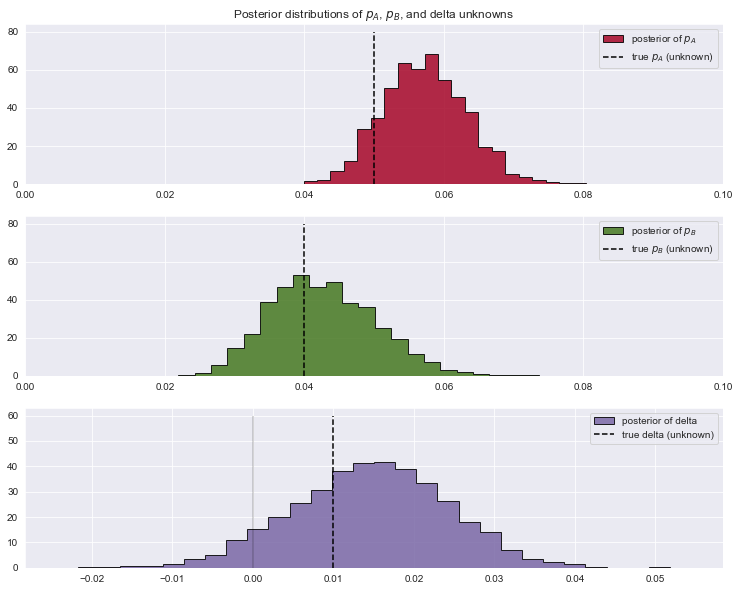

In [94]:
fig, ax = plt.subplots(3,1,figsize=(12.5, 10))

# Plot posterior distribution of p_A
ax[0].hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
           label="posterior of $p_A$", color="#A60628", density=True, edgecolor='black')
ax[0].vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
ax[0].set_xlim(0, 0.1)
ax[0].set_title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")
ax[0].legend(loc="upper right")

# Plot posterior distibution of p_B
ax[1].hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
           label="posterior of $p_B$", color="#467821", density=True, edgecolor='black')
ax[1].vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
ax[1].set_xlim(0, 0.1)
ax[1].legend(loc="upper right")

# Plot posterior distribution of the difference of p_A and p_B
ax[2].hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of delta", color="#7A68A6", density=True, edgecolor='black')
ax[2].vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
ax[2].vlines(0, 0, 60, color="black", alpha=0.2)
ax[2].legend(loc="upper right");

In [93]:
print(f'Probability site A is WORSE than site B: {round( np.mean(delta_samples < 0), 3 )}')
print(f'Probability site A is BETTER than site B: {round( np.mean(delta_samples > 0), 3 )}')

Probability site A is WORSE than site B: 0.07
Probability site A is BETTER than site B: 0.93
